In [1]:
#pip install --user -U nltk run thsi code if uninstall nltk package.

Note: you may need to restart the kernel to use updated packages.


# Import libralies

In [2]:
import pandas as pd
import json
import tensorflow as tf
import csv
import random
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load data

Load prepared csv file.

In [2]:
train_data = pd.read_csv('train_data_prepared.csv')
train_data.head()

,Text,Categories
0,worldcom ex-boss launches defence lawyers defe...,0
1,german business confidence slides german busin...,0
2,bbc poll indicates economic gloom citizens in ...,0
3,lifestyle governs mobile choice faster bett...,4
4,enron bosses in $168m payout eighteen former e...,0


Declare stopwords for removing stopwords.

In [4]:
stopwords = set(stopwords.words("english")) #Using stopwords from nltk package.

Create list for collect the tokened words and labels.

In [5]:
tokened = []
labels = []

for text in train_data['Text']:
    text = word_tokenize(text)
    tokened.append(text)
                
for label in train_data['Categories']:
    labels.append(label)
    
    
print(len(tokened)) 

1490


In [6]:
train_data['Text_tokened'] = tokened
train_data.head()

,Text,Categories,Text_tokened
0,worldcom ex-boss launches defence lawyers defe...,0,"[worldcom, ex-boss, launches, defence, lawyers..."
1,german business confidence slides german busin...,0,"[german, business, confidence, slides, german,..."
2,bbc poll indicates economic gloom citizens in ...,0,"[bbc, poll, indicates, economic, gloom, citize..."
3,lifestyle governs mobile choice faster bett...,4,"[lifestyle, governs, mobile, choice, faster, b..."
4,enron bosses in $168m payout eighteen former e...,0,"[enron, bosses, in, $, 168m, payout, eighteen,..."


# Removing stopwords and punctuation words.

In [7]:
import string

def remove_stopwords(tokened):
    tokened_new = [w for w in tokened if w not in stopwords and w not in string.punctuation ]
    return tokened_new

train_data['Text_tokened'] = train_data['Text_tokened'].apply(lambda x: remove_stopwords(x))

train_data.head()


,Text,Categories,Text_tokened
0,worldcom ex-boss launches defence lawyers defe...,0,"[worldcom, ex-boss, launches, defence, lawyers..."
1,german business confidence slides german busin...,0,"[german, business, confidence, slides, german,..."
2,bbc poll indicates economic gloom citizens in ...,0,"[bbc, poll, indicates, economic, gloom, citize..."
3,lifestyle governs mobile choice faster bett...,4,"[lifestyle, governs, mobile, choice, faster, b..."
4,enron bosses in $168m payout eighteen former e...,0,"[enron, bosses, 168m, payout, eighteen, former..."


Create list to collect tokened and removed stopwords words.

In [9]:
sentences_tokened = [w for w in train_data['Text_tokened']]

Import Tokenizer to Tokened word and collect to word index, And import pad_sequences to transform tokened words into matrix that's can process in tensorflow. 

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=len(sentences_tokened) + 1
test_portion=.2
split = int(test_portion * training_size)


tokenizer = Tokenizer()
tokenizer.fit_on_texts([w for w in train_data['Text']])

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences_tokened)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]



# Import model

Create Depp NN model. First layer is Embedding layers, and I use Convolution layer and MaxPolling to filter better.Loss function is spare categoial crossentropy because the classes have 5 calsses.

In [12]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           2498400   
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

# Plot Accuracy and Loss

<Figure size 432x288 with 0 Axes>

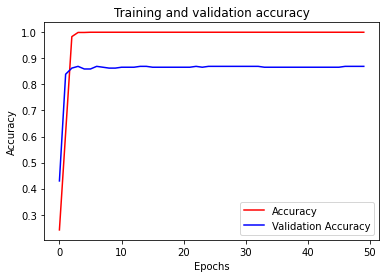

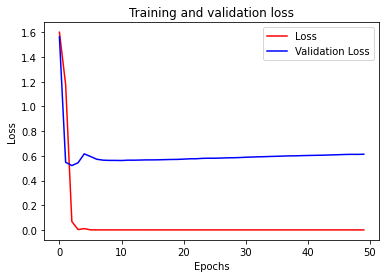

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

From accuracy graph, Training accuracy and validation accuracy is neary form,but the loss of traing and validation is apparently different but I accept a bit overfitting.

In [14]:
test_data = pd.read_csv('BBC News test.csv')
test_data.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [16]:
test_tokened = []
for text in test_data['Text']:
    text = word_tokenize(text)
    test_tokened.append(text)
    
test_data['Text_tokened'] = test_tokened

test_data.head()

,ArticleId,Text,Text_tokened
0,1018,qpr keeper day heads for preston queens park r...,"[qpr, keeper, day, heads, for, preston, queens..."
1,1319,software watching while you work software that...,"[software, watching, while, you, work, softwar..."
2,1138,d arcy injury adds to ireland woe gordon d arc...,"[d, arcy, injury, adds, to, ireland, woe, gord..."
3,459,india s reliance family feud heats up the ongo...,"[india, s, reliance, family, feud, heats, up, ..."
4,1020,boro suffer morrison injury blow middlesbrough...,"[boro, suffer, morrison, injury, blow, middles..."


In [17]:
test_data['Text_tokened'] = test_data['Text_tokened'].apply(lambda x: remove_stopwords(x))

In [18]:
test_sentences = [w for w in test_data['Text_tokened']]

In [19]:
test_tokenizer = Tokenizer()
test_tokenizer.fit_on_texts(test_sentences)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_padded = np.array(test_padded)
test_padded

array([[15218,  2249,   231, ...,  6853,   234,  3194],
       [  235,  1789,   153, ...,  7116,   601,  1366],
       [ 5143,   475,  2609, ...,  2164,   428,  5419],
       ...,
       [  717,  6467,   734, ...,  1605,   182,  6467],
       [10084,    94,  1416, ...,  1668,  4269,    13],
       [ 5637,   574, 15201, ...,  1346,    13,   801]])

In [20]:
predictions = model.predict(test_padded)
y_pred =np.argmax(predictions,axis=1)
y_pred

array([3, 4, 3, 0, 3, 3, 2, 1, 1, 0, 0, 4, 2, 4, 1, 3, 2, 4, 1, 0, 0, 2,
       3, 0, 2, 3, 0, 3, 3, 0, 2, 4, 0, 0, 3, 3, 3, 0, 1, 4, 0, 2, 1, 4,
       3, 4, 1, 0, 2, 0, 2, 0, 0, 0, 4, 0, 4, 1, 4, 4, 3, 1, 4, 2, 0, 1,
       3, 4, 3, 3, 0, 3, 0, 2, 4, 3, 4, 4, 4, 1, 2, 3, 1, 1, 0, 1, 0, 1,
       0, 4, 0, 2, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 4, 1, 0, 3, 2, 3, 0, 1,
       3, 0, 1, 3, 2, 3, 2, 3, 2, 0, 1, 4, 1, 1, 4, 3, 0, 1, 0, 1, 0, 0,
       2, 4, 0, 0, 2, 4, 3, 3, 0, 4, 4, 1, 0, 3, 3, 1, 1, 4, 0, 4, 2, 1,
       3, 3, 3, 3, 1, 4, 0, 3, 0, 4, 0, 4, 1, 4, 1, 2, 0, 2, 0, 0, 1, 2,
       4, 3, 0, 4, 3, 2, 3, 2, 0, 4, 2, 0, 2, 1, 2, 0, 1, 3, 4, 4, 0, 4,
       2, 0, 3, 2, 0, 1, 0, 0, 3, 4, 0, 3, 1, 4, 3, 1, 3, 4, 2, 1, 3, 1,
       3, 1, 2, 2, 4, 1, 0, 2, 0, 4, 0, 3, 2, 2, 2, 2, 3, 0, 1, 2, 3, 2,
       0, 3, 4, 0, 2, 0, 2, 0, 0, 3, 4, 2, 0, 2, 1, 4, 3, 3, 0, 3, 3, 3,
       1, 3, 2, 4, 4, 3, 0, 3, 0, 3, 1, 0, 0, 1, 2, 0, 3, 3, 4, 3, 3, 1,
       0, 3, 4, 2, 1, 0, 0, 2, 3, 1, 0, 0, 3, 3, 4,

In [22]:
submission_v2 = pd.DataFrame({'ArticleId':test_data['ArticleId'], 'Category': y_pred})
submission_v2.head()

,ArticleId,Category
0,1018,3
1,1319,4
2,1138,3
3,459,0
4,1020,3


In [23]:
submission_v2['Category'] = submission_v2['Category'].map({0:'business', 1:'entertainment', 2:'politics', 3:'sport', 4:'tech'})
submission_v2.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


In [24]:
submission_v2.to_csv('submission_v2.csv', index=False)